In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, kstest, norm, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Non-spatial Dispersal Coverage Test

In [3]:
def test_nonspatial_dispersal_coverage(
    algorithm, speciation=0.001, seeds=[42], size=100, sample=1.0
):
    total_pvalues = []
    total_locations = []
    
    for seed in tqdm(seeds):
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: NonSpatial(
                area: ({size}, {size}),
                deme: {size},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalCoverage(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        locations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the dispersal locations
        locations = []
        with locations_io:
            reader = csv.reader(locations_io)
            next(reader)

            for row in reader:
                locations.append((int(row[3]), int(row[4]), int(row[5])))
        locations = np.array(locations)

        # Calculate the goodness of fit of the dispersal coverage
        gof = chisquare(np.histogramdd(locations, bins=(
            range(0, size+1), range(0, size+1), range(0, size+1)
        ))[0].flatten())
        
        total_pvalues.append(gof.pvalue)
        total_locations.append(locations)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined Chi-squared test:"))
    display(Markdown(f"* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Dispersal Histograms:"))
    
    locations = np.concatenate(total_locations)
    
    # Draw the 1d and 2d dispersal coverage histograms
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))
    
    ax1.set_title("Dispersal histogram x")
    ax1.set_xlabel("x")
    ax1.set_ylabel("pmf")
    ax1.hist(locations[:,0], bins=range(0, size+1), density=True)
    
    ax2.set_title("Dispersal histogram y")
    ax2.set_xlabel("y")
    ax2.set_ylabel("pmf")
    ax2.hist(locations[:,1], bins=range(0, size+1), density=True)
    
    ax3.set_title("Dispersal histogram index")
    ax3.set_xlabel("index")
    ax3.set_ylabel("pmf")
    ax3.hist(locations[:,2], bins=range(0, size+1), density=True)

    ax4.set_title("Dispersal histogram x-y")
    ax4.set_xlabel("x")
    ax4.set_ylabel("y")
    hist1 = ax4.hist2d(locations[:,0], locations[:,1],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist1[3], ax=ax4)

    ax5.set_title("Dispersal histogram x-index")
    ax5.set_xlabel("x")
    ax5.set_ylabel("index")
    hist2 = ax5.hist2d(locations[:,0], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist2[3], ax=ax5)

    ax6.set_title("Dispersal histogram y-index")
    ax6.set_xlabel("y")
    ax6.set_ylabel("index")
    hist3 = ax6.hist2d(locations[:,1], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist3[3], ax=ax6)

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:14<00:00,  1.63it/s]


## <span style='color:red'><u>Classical</u></span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.026321739469598746
* statistic: 2124.3850088492945

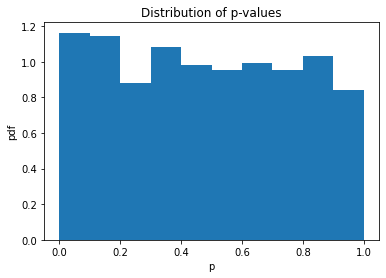

#### Dispersal Histograms:

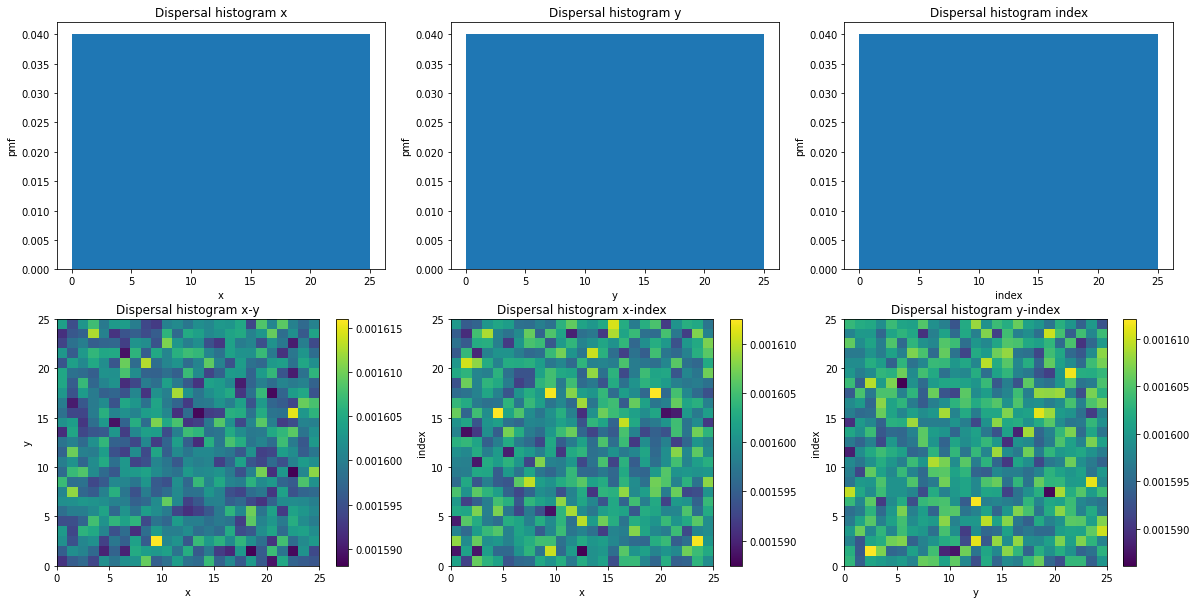

#### Parameters:
* seeds: [17020398921241243267  3270612829075684763  3757263939586534073
  1145935420576392158   902027319668522952 11841531590105780761
  3023785140319837946  4321590390270727565    93782840683044749
 11269976169376821038 16797904721973400605 16159847016378541294
  6550583431064894693  4904511271347959050 12644315058509986755
 10976767494069357562  7058709062151892162  8452792858742546642
 12351561353301705030 17317512715089411475  2065988175631109848
 12708951643427464828 15557654284837899578 13158864047138654490
  9355017861355040665  8776561766701941691   862583141904208076
  6359116033618862918 17549631644921454958 12918696912969702569
  4561099348476532682  8085379332429054405 12412429695376390065
 10909324641808432037  2690241440476951889 11948762466066233681
  8385746302308910775  5276392565971084438 16271300892757168087
 14714379525145500342 11638407802032373830  9050207585522259825
  4195972942806874094  8914831214364631985 13631794937917823791
 12615688748814396695  2269186770730403404  6208522299826863729
   148291034108175651 18092723272716536505  9288729831245773812
   815321573813058349  5789657554850751162 12961589525392866840
 17121218178359668951  9877988790411349919  9234966599733158320
  6443065723996738728 14945682271512277701 10912759666384535979
  1394460427350115148 12546028173953725310   829912129366205378
 15742526105012896357   107346685566212847  3125834886339990973
  6117266922918537959  9763595253561533687 13110780978465123504
  9691654669750018329 15472413996284291137 12168746264862485185
 15634683051410989569 15655186230443671153 14295787262276174440
 17522393774571421449   715681335184825956 14154893509601295146
 15576130719306164110  9424211945301592300  2618161875828004004
  3757571802317882552  8006718248491093748  5865618229118010050
  9419706038415388041  6084258424648912864 10095165758797694339
  1279570560042195966 15551694597691599109  5426635655248158798
 13586592797341849932  5204724183711112437  9899330887717292114
  2100860657531355194 17134506947041192700 15023578020839817576
 12212635368852461841  1810820758023521643  5782101792256412389
 10406710015925911974  5696089272752522598 16183574923386415007
  3883421259737943068  5548766569156132775 18388061353824453187
 16586217559019693792  7236093672529229219  1343722075244694415
 11713257284353971273  4505064354505601227  1004843684853807112
  4435000418531395113 10832743016579481229 11327374582447645730
  3789125460560905118  3659644200909261846  9461329431834291147
 13240192272556177748  4478753177408183382 13470962616529891483
 15914635677225382011 13116172038633938152 16283616551196244939
 18056167609719029193  2385704390261391978  6801031485568096513
  3699131267787640396 13018031082538123661 10051912711122191485
  6145151100909598615    90146324165595726 17459706079272425608
 10250721122437359483  9061679847223874306 13521187169544678404
  1538198207431932749 13830601205561741726  8207278006032557866
  5615592328766496010 11695133506142636491 10595637989069767647
  1439449941272901762  1721111699858359912 16964580179929136560
  4102168674663566059  9037409513026705707 18396895653255532324
  8492347592326775664 16200214096000260112 17863742063821224136
 11068392970224980716  8722661532332015603  5961645875250841855
  5645495089804382458 14037165012500509628     8475210805828417
 13543891641227933586 13958869028129407472  1520825460517368308
   453395113988986537 10420448974291916815  3617319652062303859
 15987511640627567386  4121697197557610131  2881134444290596042
  7654577461139529183 10004867503428084223  5420337724723799925
 16816362409643012408 14853762587337519428 10595077639286943986
  4007774343157358078 11791351614849488009 16660050651353454821
  1913715951966833963  8733974453703164454   259039256520052248
  9020962900916844949   448492731453623592 14271285736502182222
  5517025348130185237  2152762290800628647 13191738384425413007
  5910168234581925847  4376288840080528101   213154058896018716
  1280797075096599789 17168129777982429064  5087096869658641695
  6239939501268283106 10333740147301460583  9407962081391198077
  9723811973949330068 15753383517676674918 15387948389740244912
 10720726095687666241 15297665212643786717  8875677013097524141
 10241169694237785930 12501440799131240077  3701633173292406261
 11836220219953984695  5060567482240309423  3471072118570427516
 18111316431012829539 17669539236808505225 11621191853743356989
  9044599624216747914 13276281460769190613  2961500402244661603
  1222517579284241835  4254859458341784734  8753165646484183536
   518439198176056902 13066040007745948529  8875189166325949120
 14316558254586133775 11567618008017168985 11214236585560639951
 14952226471986852337  3488493432348389723  9166465927668255890
 15844230692827523762 18226684974685019845 15507264450685958782
 14703265293412614420 16585025232661399503  1519351877148800598
 10973334957860206890 13781019112075205381 16117987638291788219
 17603694238013635389  8107771732181671807  2582050408195241720
  7782567042134697273 12534284528015344878 15022362312111915531
 15078180045202833748 14914490619192952974 10020865615088256792
  8154331920714061323 13639667702043653436 13696793320343314711
 15947299063845114765  8475762206636178874 14213501533313796269
 10719070162808094891 12413033261545088991   755749297316049751
 15206686215446174531 11641722787006109062  3147340460365091437
 11447942523311191600  4378308201201646227  7193694121297853714
   133816861310018051 13647142115458193646  2553408819213528579
  6370062172267527511 17963788749942759041  4974389659062812432
   410719303506288164  8649973664635392151  7316554753321297378
 12578333979198787339  3327813353608868068   410350240951931294
 14934758604873976867  6632336796833151375  5250460607641096526
 13013649958144546917 17413449573464424778 14553199913505491175
 13795330146160299881  4155864150793635535 11053155843561038487
  2521056631932653960  7479120377263554523  2648636847874703800
 16290516871072358850 11576854629472811659  6439231150412095840
 11227071004772808213 11700097865023744326  3978909668781299675
  1414346783084384390   766821708927140833 15448477846241475696
 16490294277450744844  4039594684427689504 11363867638636139632
  9934653828331437932  9632683316903815778   633481118223797776
 16828660144532305565 17817279212441972592   929033121743025277
 11072428578717663128  8232162635132149553  2523368867802458571
  8615172866778276707  8441336139860866001  1823865512648169194
 15453372166067805319 14464785226792152356  6199976079109679790
  9239238761642764488 13005610582275618308 13712195446239825916
 15940624333582323969  6090724400395111620  9431598608807754499
  6582283255645217915  1037716320616065782  4750285944452322830
  8309211109095424913 15446975882042484711  9607002081296656830
 18155857398681356065 13621078173247902388  1865331194349715184
  5595501442550369340  7269843305389519467  6938916236937157345
 14926104196369641892 11414794201241240690  4652438127332563467
 15845947390281707556 13436132593066810934  5583786032079630809
  1916338161915113778 13332768499556803574 11081287676978095921
 13874893439294831826  1942874892688280603  8105846233243863902
  6141391319859635241 13682079273374145866  9307732442370576051
  8566510737886247247  3436271502198769402 11962505732005107277
 10724882973988737939  9338938617158592704 11375801500951337987
  1226542030253862104  9489394403123418438 13296338024839383135
 14150640197704215847  4859322082265666003  2141523942919620925
 13881926216879494650  5742092620235550038  6215757429666415853
  5334278062856909152  3335370775517659338  3227641718812477565
 16357360452259281028   618898581678040033  2199602962684251877
 14184526296628943690 13113608186633850437 11479327424836494977
  3000147462963449496  6394695821239064816   751021717931898609
 18404535613278599469 13868876563212285265  9778473577920045735
 12820872216287389755 14677459925723796800  7613357507925234724
  3180753561518623274  4552220011528960329 18134768453608839411
 17852599895541558463 17168097449698511625 13058699160557807137
  1876101900726502437 14021788656302852421 15817352271422405339
 16323166997980647039   650376901905131795 14378007874725173898
 17192426962034694702  9403279118841657140  9354279693144939025
  7861570940326762278 13762271989688241675  9267080179725858709
 14288268789523866349  9567166927610025715 11711094922342465116
 13777160862816475646 10289695667776533594  2726272985210596966
  3781927646430336021  4535243149346245845 12839066751686333982
  7622917401956133599  7159481573077526543 14656621096856295379
  5811104681633535915  5976197680050796835 12035041295427361288
  9093637014341732557  7874797403906751370 14611631900898611280
  5143358825463849934 14927993300245890968  4245554022623976591
  2360465768505094374  8411471337910926590  5803879347962489763
 16662960624796495151  3037176625642717929 16142230118570202756
 13444285703350550733 15146510384134774393  9123489300529995550
  3283870912839282992  2098027181762148796 12620724286120895104
 13915630218824457959  4608152375576126705  8949981008478205380
  4951806468192339578  1437943008661341921  4476665854001796853
   698689279957849495 11887889980850616709  7318010517336828802
  7724246764908875684 11635367646794057515  8491138927844854617
  9359632034590421090 13839523002688436114 10866510936195843103
  4583061781767867205  4047685517384453808 10704273646020627943
 12990141049803306352 11342121071314479044 18050892384888841216
  6900480720791507541  7115303396923417882 15420349855604022717
  6579574066089150084  8740796492235691675 14962094789035943007
  9116955856684796791  7200799593166223086  1134472727757298238
  1943684325013409199  4942126542759661779 10612809355020974910
 12075495634135845031  8713466285585305174  7450141966712371349
 12782837101348173826  2390088513271640722 16683079828180913358
 12238399031405617120  8278690799823243596 14155454009131067453
 15709483748895076380 16310311075136325715 15539314626244728602
   477831394743029714  1645384791663580862  9221411654455577998
 11189158073761283867 13722762535573170924 18217847518509209632
  4773481594685082463 16621391353013499923  8756870105226655892
  6217148458143901712 13900068065891625542 12897811664229949572
 16198043769882878394 10475016368304198995 17190034771329933951
 14009303103110985493 13228184302538203510 14457766686966016661
 11206420355623308672 10253009071802565888  5948261397398253804
  6399212443974695946 17177394688464429875 17381540975700195245
 17196857484654782955 14512223096220754709  5728789085968325702
    74401475656648599   925314279938571813 11586288851800552733
   445859566595501622  7312834454726152224  2192575371498795555
 10076503928518020698 10383985411184050988  7142882973013907920
  1777629157913531602 16025553090552108916   782859313282902349
 13019728878529238169 13062084366724333093 17644086092615832076
 12268181953284265349  3157484880128003019 11544612670303344957
  6672602337407264913 12254262733238651073 18018025955254388198
 16476181761170362377  3550377586776371843 13529112630937166706
  4779630046284737830 13377621227212221708  3043001667526989769
 10621332997944442829 11042847823525852129 13972750280894906535
  7908746649871246092 14032855377008833675 15399579464845879343
 16477247510565513453  9562537439541146327 10200024542139222903
 18214723445654800923 12434431099672246389 15128575407776668291
  3478301545758690143 12593998375816207938 13749538551198241191
  3149457221509463685 18033699878915477612  7723096228691779140
  7787519749866373105  5176949308103043921 12632067107337736117
 17686880254113390192  3104149215984406509   649019934679000021
  9986381987259591361    54930375002003847  7464059453208982322
  2976221458812243469 14708893018052436246 16427453256305988456
  4621337727102710886  5369379920947758773 14826026297296892848
  7802365293109447015  9480546264108983073  9831500340166168674
 12773731095846679732 17971392953873655715  8375499625750858861
  6575067452323652180   608702877778147063  3068661501667359557
  4898366489380545460  7282332485236571039 14760254550165136186
 17019144752403199906   871698319428429191  2578178577414699348
  3453124634267847491  3310312325998727400 17508376557397102441
  9965284369209847398 10708565984341728362  6776299045292702438
  8250429739573711222  2119209741644941426 10418594584070727851
 14508032037123765359 15274477085276575645 10430545299824606486
  4308779435439218350 17760288906610775271  2212487020353863363
 11817224650831578941 14266372650182224984 13746611328203167880
  8547134377533969460  1131676401901798482  9521278681811999515
  5158829731203373208  6227352201800826793  8761967279493877582
 13754530327601775542 10970734317625564017 12637833443935102965
  1592626800278910093 18060376229202760724 10591459892871717050
 10106712344254315161 11710586790211549421  4843380550169234157
 17298243311519339768  3217126703449158213 10691266679107790727
  9077536620827257072  2085608582554496285  7050119509990524627
 18208143784813925887 12111866518791094417  6246777082757777377
 10891253362952629585   402733392550252566 18122112422030739247
   534513039377978001 14360416363874948820 14469181314779030455
  1110410838650357532  5416466607729456392 13531049846441341890
  5041737379524077394  4577834898924726970  5028882577529072809
  3254226882261687077   615157518492892391 10489922794144970138
 14231045567928848673 10548604575560994213 13278336046566099432
 12916200497676296251  7371106536496343668  5536884178423344377
 13418478346632105976  1526673340915623289 14740654248826503487
  6642412052107304070 14695732624005274597  5874535665199230677
 11358038511201139737 17204934175893525580  2221509237354702260
  9422123190090198290 11273529036990270933  4898650310884627871
  1710429017397792340 13993499372708861690  5284787763647453152
 10507319603354726289  2535608176928571804  9126624687544092753
  7150880557961041701  7695069364587243356  2838485271341586853
 10494860828929419772 15421691293399489937  9270300416598919619
 11794695728769083912  2955390316950206602  2911369959926392652
 17388900236706748224  3178914803610806943 10358050509766860746
  1655095397896239597  7096636435079969086 13003340692367584264
  1272521186776604102  3111400483836919669  5807473185948623308
 14782838661985084728 16784334169905088259 14184566099372581122
  1077413671285663902 18005135874149625478 15565432374631736759
  8921621151367599301 10011639826475964531 13614721762257058195
  5537209548249589360  4994332080752046805  6955897443375644658
  4206594999914173632  2371666477276350996 16463905632203731898
  4019923926435152945  5751512693606562353  3496227626905138264
  9186583044874897388  5280761684575229134 11023324661267638401
 13899628064001713864 14687357337939081280  1224915348000314724
  1109360431623610106  9366148155474652853  8180925380476995967
  6882982863592594526  7088716800327828599  1140033959272371061
  8021208177089627380 14198890300818545313    96032822327977024
  1215983159165986472 18136764172776940783 11798978303527844663
  5998298946903616821  3245371524741490047  9432837480035572854
  2003648267602620338  4379320331528515100  2025367860582931337
  3942591554687901714   115754081322490567 15289293543718201107
 15710438401150134018 10757415631659873959  4036481963501309639
   153897555239462732  2154653633546890731  5764499701511062130
   920120444291426529  3890886423787511937 10412717993582648013
 18193473599196383698 18167713181268594354  2876176072262898371
 14265716143152750671  8216374220766959193 14084081748797107559
  5284572521491926312 12301257415545820623 14488117896365565128
  2577983559774465418  8325530820529498385 12548035206307216640
  1696752913982512446 11164218869986349146 14461546642229466149
 12171116185719586663 17830452933164247296  2102875141564732879
  8549088767743521903  7897630873843316449 15298721347466682712
 15256819029772114312 10013784571930234423 17218622176286784477
  9085269912756798565 10856783479626213079   885824678690362163
  8484901044017586689  2187688222658285059 17588206612817349445
  5934550611430246173 14472762956308041080  5700064545351080464
  9317767856082199396 12346307950599541132  4065832793821117554
 16804461692387057649  3196389611674489991 14662303376721740608
 13410678056070418309  6999391879560105181 14500352968766424033
 15272619014603895070 10129251501248624625  6759901152909373343
 11471474821249670964 15803520635131273121 13680829108002412765
  5426295410256051771 14794753496082232995 15886234350620605971
  9099489562105894313 17910123156480572784  9250027307015777483
  2583102282169966631 18151367792459235585  3888334153630406964
 14458531169021608620  6022376156758135197  3172057411568564042
  7971759159396040428 11949199749514134664  2560531338578491951
   602039533553298280 14287348108719828002   239154720609345483
 18372212788533082552 14006491941428423182  3357160501918389395
 12568040917730106792 12907919568135312170 14483687340793879044
   377594864768064948  5088537058728244433  2928769749528128658
  4189492749542010161  4968271234306741061  1155810069834480943
  7885526973653373244  8430241336255634706 12207164943871375192
 16874106798242807525 18203347686124528250 18238023914063426237
 17837748814683511027 14100244867282044431 16335113141016054828
 16733115612088799679 10159154081048170410 16863545811857595740
  2716732291676283489  7683783975965733794  3512804082474984363
 17711789533086202457 11258100196124189865 18295269677183468775
  5706969590142709263  3879347023706232619  5823559166645125025
 12912083531547069192  6046327576131728943 12319234892710109382
 12262371203190064538  5312665908356088144  8069655819187367671
 13655118312073277432 15180148471656804702  1121153886024544088
 14726209915272428068  6146213293537275361 15150631310424054290
  4950302843596063811 12248029013052757772 17414974152270663749
  8483083314261626966 16685035736744650627 18217882501907764914
  6018036106243936861  7089424871516209623 11400362938232350004
  5254472113804541758 15625571255773571246 17605434772690331602
 14921559386484388004 17734355350737112878 11458325887008663029
  4785429125253707206 14358874617548970001  4137207727668195597
 17366543892531270214  9529003558539738863  9012353065679022731
  6579231864465873232  8543075921293292561 10104267704014805822
 18162986388593949517 11213406434775116439  8199276619389918558
 15402320537228644805 13899878077727464741 14348952912029967551
 10409237402705128488 16596770354182801818 16948893468844941167
  3265573957820593553 14269974771743882584 16322093999525864316
  9009597155908411799 17213757214292575700  2465282731501924495
   316517399049125140 16563135603982822280 15793063524698981898
  3043773581612977577  4846654582874113222 11189465935907114265
  1614859868381323532 14056668257344183683   611162006471817488
  8589699704595351114  7308674227735458795 17202168312712182129
  2935589524347415850 11266269917344729638  7637678424640369947
 15982576028305487337  6235371552518783883  6732794148653480565
  4282329625183587553 13996185470738436427  6052081394199629550
  7062256630254668597  4323889003887430737  2143073962802502450
 11267868710265847221  1429436895703303943 18161747062025208223
  6881708993139552059 17957439308733410574 10050754383218565325
 14604313111325841994 18290689086628528289   888677180548372080
  2262826519328577822  6205927010960433246 11904503130352951262
   370367603580173974  9822243630461742330 12984448396974348821
 12952187846636662874 17212420340728403138 15635939831051991374
 10619253642511968715  7654763336115121729  4932109456581463053
  2120906657632846456  7456271613956070187 10116427376206677935
  5126127276808532792  5513181783302079244 17208667867280129776
  1903576443388220558 16875465526462205162 16779137829500995180
  4347716397058427566 10930286164154449896   306486905997347153
  5895797307128945935  6403256764775983625  2557886984240427536
  1197628439603926280  6164699816547638713 11798151312882409217
 10278590140842920191  7608003444017410158 11675194660071310215
  4516008438577101226  5454121474926834777 16618375861383863390
  4279419652559976752  9626489922796199325 14376875816893277939
   334520847340387408  5552561455702988024  5771419994553313830
  5442010384744353702  7011041666745457118 13063295221653116233
 10470327919397135934  9765899496653999301  6337125032652832555
 14774326818896156814  5559323537912183269 15688293453843577546
  8861161790466083462  7775390820176343931  4796158062501298498
   922409590496181695  8400564529037665759  3445129191713885821
  7564192841656441813  4755337345704807588  7121670429542003373
 18393858854368899238 15113011750317745724  1005107568981373772
 12684726888990394862  6380082285352493680 14183545039495507619
  3957124744406124810 13347080426988092323  7682346718314383837
 16618511598321014071 17991563282952566093 12899668133297000361
 14881157334525185640 17792425852159704519  3448642175460559111
 11102495210764734506  2287286309930095452  5590470776327305018
 10127899078040910599 14658154143610745486  8685240066464421887
 16521683913812515654 12238739001121792199 12241448608107577445
  1753827385685261596  2442394285165661366  9677323487129500662
  3756215563790077873  8343533640593450813  3746618232169676029
  4727772415344087523 13185685596239610296  6438816082115254777
  4906092048687148942]

#### Configuration:
```rust
(speciation:0.0001,seed:4906092048687148942,sample:0.01,algorithm:Classical(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:42<00:00,  2.16it/s]


## <span style='color:purple'><u>Gillespie</u></span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.0002683982176643386
* statistic: 2226.287747855928

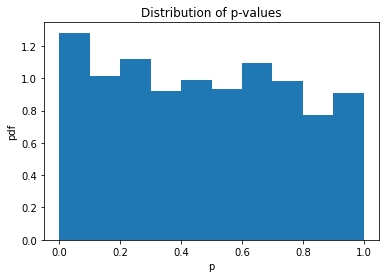

#### Dispersal Histograms:

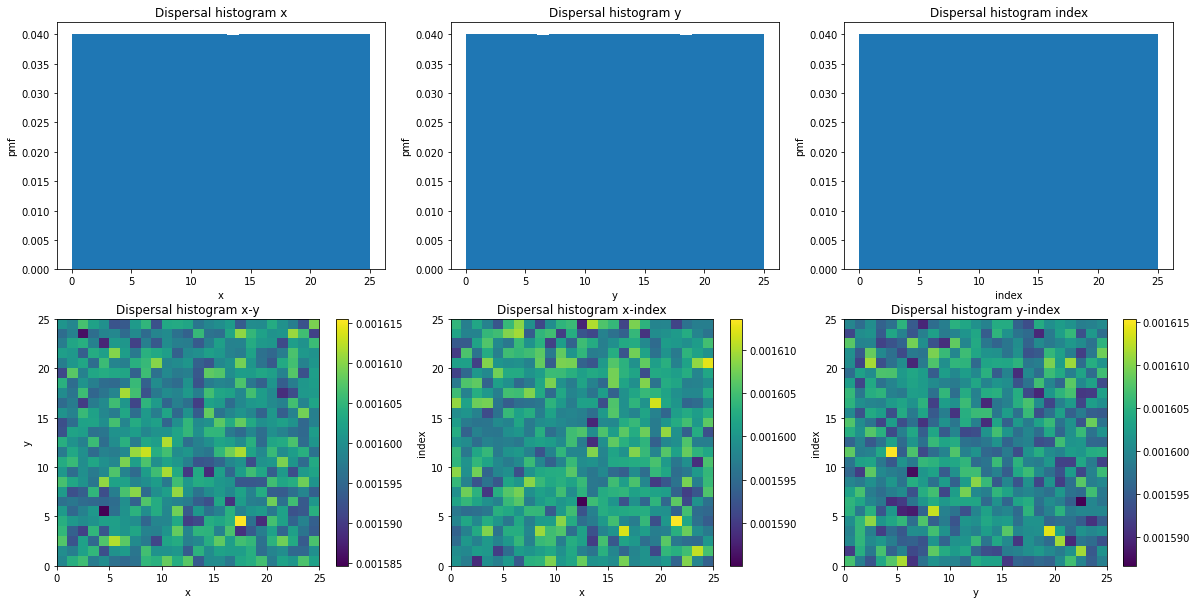

#### Parameters:
* seeds: [ 5387330362507630122  9679434676740427391 12196554498949762953
 16200727010836500450  1155853893733158494 10590486095143905984
  4931607533235302037  7361563721857823578  9708677997603018680
  6149089527610350984 13606991832495910097 15911810324202071422
  8108688596101993603 11227529807488382760   635621212458639030
 11550329114519446190  4047557707128528380  2032177066211161555
  5720664908495696975 13159784702617867181  9410325518409053974
   710651991495360938  5638420563403990829  2715289202625516227
 11098141898197110986 14503045661126484940 15110444313861519693
 16007543386564408223 13419363444831930739  1095011009795324030
 13323737880962245045  6730939784218095286  3759125134399767908
  1028449637551303250  8283475929905148717  2254375128883974381
 14658176789621171267  4645308713228818763  1223974176027664200
  5647109957595722805  3918958731146392251 17897504187281424303
 14614886709964508087   203772224399250439  3447017171378620837
  2542583085108857794  7341548016569472076  6427538252822572095
  8542308146303367486  8713998639731736240 15224018451740929772
 11486008546292474579  1885683684392068676  9383260601744608580
 13519937401378975560  7745167596714531364 11580767044748122332
  5718691055265598421 10890219871752392731  8744255016991181291
 13570014340249408235  7209068507458595624  3028765196369170987
 14885793543952907584 11566256781611230415  7887522790513122914
 11304625686433357020  6197244789666375471  6659640471842017487
 17558466005753281592  2845829719059284387  9607676746012865783
 17455492116908760436  9718623978311526069 13025972114560318373
  2601392704204223715 13742428948994968609 14350103276329229698
 13403767461074109047 16790941747411532212 10890213714145730522
  2764890748334570497  1871561139477604429  5188789300253732099
  1036994883128741292 16752772305028858053  2947057841847818816
  6796178653955970990   791053044473006059  8304319835340050028
 17313063597205739974  7484661587477088550 13303672285898539612
  6425984373677976401 11740638310182870117  9760630936881210147
  9320361365827904018 10564262790707116272  8133554459400297497
 17339337753927204725  3301171553006791881  9709526862594361900
 17432295960016255643  2545220979895692252 11943898068766486804
 10685822107863622263  7644775686067725612  1352424359871707355
  5634530813264149227 17671636058379989377  4041684968906695512
  5155305020400742571 13079797082488548322 16336043525534342037
  1305304862341641482  5973049116952322698  5163115658708033806
 11315712871785237908 17890433274254281484 17234566526590748820
  8322930224724210113  3357698015500329175  4958189300513491066
 13275620676209367253 12781279157779233503  7885094785236269022
 11255795011944776137 17803319807864812782  2159139293144167894
 18370813495162147227  2478683223693637014 10394213498222801102
  6266807918516525356 12285767464825385664  8750871633047068541
 11202671321876976868  6583415473671862227  3477438211289898587
 11077927655004984847  1542211606995494059 13258348693977655044
  8764837191252329838  3881871177871876027   161669613072559015
  8542342537471394070 15254875228395880375  1135185906652053542
  4273811415591037105 10788153191895936359 14645991462059325907
 14125601723092707845 11764388230038362684  1388425261194528779
   388839106654159180 11672732604825623496  6652084810203275254
  2307824875522516539  4858430443713222857 12304593816256571656
  3775389601735191105  1399808974838391402 11514210389378177203
 17323967453132928924 12809876910502326989 11021625930996303290
  1813328965938546226  9523615337863312146 13763027780499425051
 14942586526073990287 17399466418972589076 13030794381430849624
  5588537212037764609  3833767388869907470 10018697793070304490
  6691971791703225401  6596917172100610735  5211464237404088814
 11156414389403072624 11422793794718050929 15850358376799333210
 16210485930727889212  1951143690562825373 12455059252239513804
 17599762296688403276  2897146730587350863 10118306257868358547
 16713585760969213109  3538868141866359785  5618330962272757285
 15190880697351678493  4417295954976706519 16873611369586515445
 17145791792395044973 17783991032844660792  4884683584663498994
  4584965086341021267  8252415944619410562 16108440870759737199
 12359994784058770856 15473997552528284097 10858166310755959977
 10398478379050189604  5644935156991137839  8582739619891267419
 16627329286708517145  8898738529604741608 17196490760514621726
 14723929795994490413 10034637454276875442  4250718774708210274
  5935097787206454611  2660646798641630005 12815363253671026059
  7312084295384962237 17655085867162649202 13908601258661006458
  7180941875898694548  8669288336461351110 13301018083419204446
  6784478594861453158  3624009500093194332   803933778149906191
  1691734734628799161 13111106411582163483  8416119352161653023
 16995174832627242165 18398809547928711079  1642413113800513507
 13263038124202476398 18200935903355246205  2401438617123792429
 14802091191492553832  8458887274858453522  1791577082767905033
 17245608864269716451  6506992358339408000  1885272279562238161
  6822240764562346991 15036504819462857182 18282410982180631199
  6706977139805580645  2514303173104166700 15570849528120963021
  2927250694354846219   154610883856024882 15018152045764365779
  1514504482434872733  6692159750764379543 10939181461476502854
  5155638409803784211   674414202366243347 11082947356864477953
 15415437801100651781  4572919933179357731  2943691854170872425
  8876716704287746509   275796500059003807  5997087705068137676
 15737809147243963126  1273390385811465594  8646399835642999717
 10949954683577029901  6021322759913377686 12609728073133164196
  6042955192566893468  3536437808893404159  8108350927095918841
  1319433240024862134  9073886708834838590   217451232611472602
    52411771039723630 14779183882532182522  4634373896017992948
 11580754394927623617 10904445380853796424 16934635802263147551
 10319691395165510736  4855566476815652688 12288856018166233419
 12331141095158494605  4098260778178050023  1808455150736610876
  8474034918988281001  8145455223503519837 11091547286699545805
  4750782625960147635  2325567033922791725 12421388642037378353
  4877551677355910919  2600330582375978814 15926154893150134383
 17956150551266790772 11110724065904487855 13963882640321826512
 11209687896291184763 14547357221770042714   724451665503147888
  9609678386797675666  3822652103067751289  5949672511521346526
  5312002138308651643  7010903672528238905 15817052688748877495
 14994498201231592710  6531997759864052072   390101789116688892
  5331807615626357988   614334894698815757  7821936767485116026
  8321407538464315906  8568059421335021843 17918774712112355501
  1053522236828228583 11432705481438588626  5328181730943047659
 13525198330211401291 15309881925737887657 10354999559291420309
 14933917933161908925  2762133791480929350 16040499624244299847
 10434329306476215898  8079765473238274618 11189732057777573178
  7549080669332480209 17112005729381737480  3932475992736685982
 13422682933873042347 17470573421910891218  9616245421384099328
 12317146616976918631  7478201757391123497  9083285333573226296
    72698641045924016 16561355332522374703 11149691340436528077
 14230423681914575328  6261499880936247274  7538846177673811484
  8563078797993807338  1566278525244568744 17506792706858825111
  3524036795784774734  8417223917886202352 12874305160735467392
  8078680697630164688 17074391243385017885 16043554340557064809
 16943760890406875308 14986757019346791648 11133359644485501489
  1534641801624779674 13255562895840636545   467472098275708080
  4881806240846442074 17418122275720333078   313597190821468803
 14345670670193429215 11914804739378851976 13324487931488875573
  2666306422716370406 15265075085061233967 17286399176424712379
  5037658496877736095 12127393713886381076 12976129786536147782
  5538358985083868242  8695649403208497675 10832730263273067962
  2597393309078249835  1219173142887819895  5402807961038307540
  9255359241284299058 10586941690558191628  5175176273846608303
  6772398161836011158  5994930222592198945 10921093177912061405
 10855335275377703665 13814677904185446367  5040606764749099536
 11014208796740808605  5550896386455053040 10360066112397228969
 17102370107428676365 13587635739468435160  2234153890919392999
  1399683950478997161   224899328709908576 11356537747494028730
  2309855813157120485  4020860796467071108 12531297598147504216
  9788353471400871804 16080679095093169370  5339842526849021957
 11943159089334257446 17773177106387132022  6316662135951658831
  2138854673966636240  6300308929390385998  3474332756609860356
  3688434737802829039   290416556100976131 15027585343210705153
  3803364249567597224  4661621466746212786  9333134146530770350
  6452788847920281295  7516891319686060733  3090861253076008913
  4050358644006564948  8451652200294716713 17473338313679575288
 12899823606056393077 15065948138482191330  1615441273419826240
 16335219910895820336  3602445001887815228  7376947715038872363
  6903338978981730081 12549714779493181679 13050617287737507513
  2803134818907928661  1317115741644763171 16538559491543192354
  4467261582476023741 15619405898634979551  1319873740998909225
  1759926741472944589  9488511586734085457  5401730700410120547
  6783974689380034091  1878392101013441370  6367144146266299363
 13407904664001951504 14390775543762880147  7467456732340673327
  4036056065229839385  8960429776820268437  6997261805268320155
 14255455079333847744  2213016963164982922  9679492045803606050
 16772767878035744946 14773661932642730182  8676106395226370694
  7505378218411678036   353773764119159630 11304904419090623088
  4883167959336928752   950155396028621088 15724687685287175763
  5583071125992572562  8651703255885731218  7007111877974497484
  7933975257892845006  1323370491413992827  8716723417302053153
  5889658618138288276 14120298296833668655 17897862485722091948
 11328571416065056937 17270030939231766546 17074101228430733967
  3506995526140287071  3367620500767785389 10668621209567568743
  9662099248310974649 16484798671973864561 16918994124956297504
 17265788027026969502  8861819779436992245     3155626620617186
  1638763928698359563 14413848888495621404  2240114697245090672
  5778711770533305363  2119481249466690151  2300880734727797991
  4403531149597955400 12368238910059865322  4945937229297763164
 16163085290279953297   456742244155695762  2518795865923409675
  7298885051058008918  2826428770974380648 16151521213418310287
  6845324213687675555  8448269384090534757  9646435172024650371
  6582745470409983065   286501953310107729  8481726724132483650
 18012454628294625670  3893504706216909537 12193777786230246753
 17691957576726084058  5266731820320998999 17026814445951886911
  9375334412296219936  4236501874119751376 11506943953884673769
 14071810907813149080 12035288752905363430  4705091868880317992
  4585132619434553589  1574050781834685040 17259234013739607116
 17243662841987930080  8590434861926512908 14822059146006168203
  3304073378652211225 10849056066651079813 17419561522057245033
 15819043236338610835  6919341164737811675  1716100151960261550
  1553286040096087662  4642644513568919174 13635499726993203148
 10395806004977511778  1858565430322618077 17630271223538975323
 12427578922899020600  4404603293668877275  4179664406968691555
  5193324383294179022 11958317187846950014  4006081074026852366
 14807393014883173518  7752195594414964597 13874035556535582931
   524183401439203449    11291148006071907 10356604922203751925
 13806946083345239524 12171995844523070357  1420839095486786798
 16126386713623419438 17816816153639628355  8774738392296103936
 10382634745423861433  3859108582487282319 15387918254818073690
 13447676025718852420  4205894341984965216 14979127968333171477
 18189938015059379744  8870155667832456913 16783101280383312079
  6878011250428616354  7491302726813892981 12013999169528238441
  1470511768649348840  1178328224487142822 14077291543355834022
 15012204240662088297 10370479091817206462 11824738812662258058
 12537456403122675802 18097005352675130684 16900175946743599030
 16919247821308702179  5648477285708746054  8520528483409254208
 16650597559692727135    71891205421851358 13224172047790836159
  6907928459520297182 14625536082030669798  5752702349311644517
  6560776168453230985 16873509689951574873 16552229608552389009
  8014767363801338659 12785932274344450885  4030116779597023729
 17605251641765367256  5520991995188471221 14978812735101239471
  8711479715132990086  9690197423680601925 13871152548484296072
 17101186160197607048  5330692229608326790 15009441848958175052
  9334179675236348586  1155893444070641301  2022567707720677597
   723075489999870794 13750731329632140500 14849695079922047170
 15536860619041718410 14452874094389190710 13792624801192847748
  8544839860544168341  1258573470181770913 12642753917705380152
   113666493071027870 14155825412465092220 17268571099738753295
  4820919064282389759  4422136803060570604 13232536544549427170
 17084848701986141226  9617158563324484914 10111248499982796952
  9610905981741181489  4427397662688749874 12877047104064575672
  9073065593697176596  3072069593147542686  5748115781630781778
 16671722823129778962 16927901350804971171 14629768431967006103
  3980358820658525725 17536398235014000414 13126120629308702891
 15157990563707965387  3150834011198262568  3682974932442606198
  9905347147242075955  1841309035244960520 11175868716176973926
  7234734436431161896  2449800368193099222    73074288132799367
 16087871221706425646  5410947293987686640  1282161160772436266
  7363257159074761681 15422337665961869398 16896067280402279626
 12693517458255091986 12486313846529348269  7883091702159076083
 10288578290531422364 15155942202390757394 13786795034020709035
  4702198780915343428 14349053464347182653   857959332202544097
 14963892797548405768  7750492185913397186  8111950477487542596
 16545738395018343486  8939485656237893913  1052919601196922316
  1075807642900775309 14644168336163867140 13693851826777390716
 12216803031796632746 16993796727726564488  8394466846234815431
   678115979929837786  9468997603323006136  6050391669797794539
  8724635236293992753  7198991623697803265 15672068424525620589
 14615010988866590789  6085850378422061502  1628079423315543786
 16573340392622459951 10488797096167878656 14923271538200105517
  2682291474273815007  5780589892427914335  4485485055800878873
  8593478975698402094  9705322085158515045 11770520111369010835
  7259904495010375744  5639677117699300448 13415054460946265340
  6375380421821167297  8903253045508290263 14507366864640592893
 18038838843649336839 12044688345132913470  6994857633393679299
  6261035354127601724  2878960409990969536 14065734473508789917
  6806682317453795230 15681520290980087984  9067165914428930399
 17526429134470737702  1227083177868133856 10906517911562461331
  4514360528646473117  2678422166034234698 12883590087722811938
  5911323822876894225 15503344389524199320 15656398726206092940
 16935873002497237674 15349109410798514834  3113942723819333459
  4233012066503355569 10330756296082401416 16902884524389875648
  5479439737363566031  3950727438561959280 15813992966433303741
 15549650725477495280  6639903636849498968 17664078505422532838
 13922827789982383968  1693419587467670494  9819501045937238036
  5247906038338040051  7774154681370511932 16957229092530983470
  2971069692019725701 11808139406280185553  3469152818860167576
 12013776091844426658  6401558840753041712  2136565639332664309
  6240686977390136278  2926758162263932148 14477123622513071811
  1556114411308869117 17819183071724445245  4433646047110151965
 17046765768720705528 14706313894962524642  9413295305774568010
 16319756612955618069  7524300074528011979 10453352711238049846
  4008444713544322299  1835423633820843804 16389252753590585405
  5851575579832223696 15406477409125668409 10604304399078367802
 12706392210077186208 13938426281439559560  2561728792399623181
 16316647943736760157 11680155718219284146  5895675297063600535
 15897854143360769898  2519519742707326853 17100488320655864372
 10336891517344647648 12607798355570402420  7578441142059868341
  6573741594802211816  1322090838451300654 13124067670380296295
 18181050298650236795 16762123232840587100  2748576896376097304
  6624833544902921164  4862296249133931137  3849234486223305262
  7788631643748460193 11759773854068714449  3925150798693576126
  6946715554005133607  7283903209982525966  9317296658741530357
 18191387162769625031  1717240126199060406 15679476877982997295
 10200697360631334864 18039902327831277783  9746407470107087044
 14556223650398569504 12637705478541623913  5442678630514890782
 17998156663887475930 17570019678551011552 12889269418027416441
  5906840281383324970 18433281176307014170 14048362005794376598
 11804540081317483027  2628777759202811335 10875029814992752514
  4696928002869586591 12531840078830561797  2405941936912395189
 17907320604544179018  1504216740601552081  3048284268240541869
  7976071778066456108 16483281328023416125  1738515542610194816
 12819217199292332924 11548285868686925366 18029169615432911054
 13699316691169403390  8557842792492908933 13658591229216213730
 10358492349961817676  9742735471393470219  5124729137719138553
  6522085527987644234  1431168878929827943 17895002934518313984
 10627523165428591251 17147227869895454183  8041471158931357495
  2685468767391751954 14315366204390505078  7100563145881509743
  5343924905845891373 15611270917065346713 14319403895359099839
 10073400510330755815 15035009902781716868 18163044177778176242
 12106089763715845150  7163870594654200265   620303257398721478
  5699564200828713743  3823906544295697938 15664441852790826022
  7919699134263600045 10119451795127901804  2696071477576476281
  3383472635394241828  3242559138824087911  4230483692233068812
   244706769345644789  2393098116033007599  3958127113774365425
   729389424728072532  6256333670125300087  8000255118258120339
 16246375846444933400  3656232158776545494  2685479938324181370
  9201404336544932258  6317373737680217215 14273184281260499605
  5572181639113816850  6379232421866435751 15620876033760358396
 14771253359581119492  7049045101145152801  2714126360034192977
 14682116103615992385  3253039403133097975  9357690462224111120
  2470467453423265838 12780307591960134161 15687016536205950417
  3086434894174130553  3105863715663897325 15742442059672487460
 17041167694828850750 13723420420517321384  2418040941995025645
  4131524544801802792 14621345538406245410  1932801983289921549
 12371709294187666504  4869653570677020436 17218167018187978861
 17969766109280175860  2641889019680689764  9677552017843291923
 13624396163483869778 13304359343867038437  1964552409089479181
 14041149951008688542   567273148535509869 16311736221972544737
  9260412915024073347 11635472779970000567 17103653479605308840
 11746498491748377330 11478747852819995138  7748887229129977412
  5537527798704481536  1735498166535046717  7792627260842570703
 15877485972500807506 15616304722788771022 10875977926515668832
  5234453255958107903 13484380426233010349 12069662659816409305
 13106320864563027646 16689641350700523097 13053136560314323973
   128800087028480487 10114429668314035452  5249350587765774069
 10154060364235171580  8883438115674307036  5553388565565200677
  3519242167266076601 13073435354617008274  5606431554131957978
 10475565290227296691 12777326830603187072 12698033019170508378
  2757320134366190316  2024776995256779316 12671173250528970682
  8456963719405106859 10213099195003545358   496466693353706820
  3437757768278223756 16928760038041372897  9190491673933734441
  4891410439919911959 14960057504134279273 16311482064857399999
  3802679456730819701 11414189481189331623  7166259825707403437
  6111911891062084834 13497889408462171630  8050445823365520564
  3453036457987800631 16892840187115246501  3110489458712082570
 17210260264817174092 14169098029904481095  4535594273208905507
 16749521344047305414  1009910266331886977 17940997373658299006
 16831507167858641023 16415994000291434383 13980165490895372912
  9510858396280625200 15877798296361916200  8143114263687507240
  8623705932394517422   850568962587448419  4722907199514655983
  8207347674844859501  4080067808441679514  4613690896635949860
   193445156438983100  6708840657184432778  6474290687112952213
  3343817483423485926 12355988941344199750 15607316582943458279
 14148325586733937284 17961035618401385669 17093306585055039497
 14801169452801368854 15938408607319986212  9767748755832018487
   222231998856381999 14188169304771088151 12699386454199119023
  8426413697045761090  8407647400065146611 16569342608591789616
 10503998840213013429  5517343119317458554 17987289011258258345
 15601436041603983831 10815229553715787370 11201355221980448002
  6168197401849043148  9150558898199768783   192202356544122871
 16717159633549232219 11253335530574528059 17033977840442592371
  1427497789200113877   298970169161505434 17896088033121653981
 12206469876846685382   296605143787611337 15797404576447150918
   657084705453957366  9964498750370492805  5326563005643789384
 14098200515272146658   649367263432642246  8906257832892000737
 13515992356470510900  5034388782711707692 14948550550225981002
 11682862603233178001  1802090987145821139  4462662365899636159
  4967754987833110599 13901425391626927482  6349114805372251454
  8274124461328795441  5383547227040920690  6138081038853855699
  3570975060769111360]

#### Configuration:
```rust
(speciation:0.0001,seed:3570975060769111360,sample:0.01,algorithm:Gillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:37<00:00,  2.18it/s]


## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.5365807672445397
* statistic: 1993.5327089364669

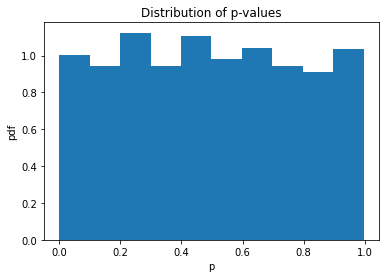

#### Dispersal Histograms:

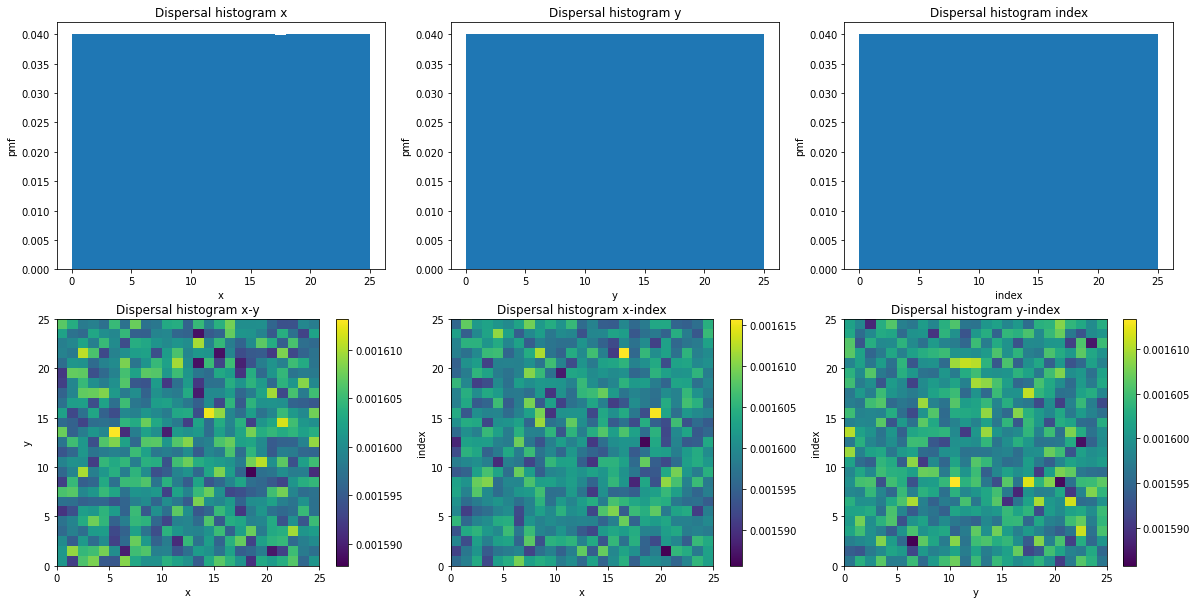

#### Parameters:
* seeds: [ 6841513020059504287 14956288586253508097 18435940061695771470
 17257874162259770414  5588092308822450670 12949769747390449048
 18357975167640332228  1078383048293913611 17631682158827132758
  1411172569627066650 15690927023381248238 13387647304409137323
 13088420560080613572  1011129333080757422 10577669367236698412
  7638555228363109732  4388598511312954091 11156792059494409947
 11063914793700556396  5316947249755204244 14675314092667794561
  3271918795299064180  5358873233685988034 11983382560484316231
  6892430331881463950  8616283794865212585 12402772667696914440
  7130403621649437852  8216313773299103621  2218322511913849392
  6692996203979227604  9376009247791306876  3169574519677738773
 10448134710362447555  1713486086599757908 13468925916275693767
   919569383567399819 17589326991314808858 14983939394763155104
 14361620281101663320  1151074911232192141  1843687744297730779
 11256299931380991178  1600602095107702342  8971312972333015538
  5615686115188881492  8032003154329347701 11623656683569817746
  1958702520363270633  3746384508982588039  3665051005368387048
   348376228493443996 12117545003679122127 14900919066034199664
 13407497813304560414   333326565134475944  2864350192399863978
 17619902767203703072  4426425423807804637   347732675880182485
  3188669546287858147 14700972896389233228  1306138934370851978
 12000675158190037518  2157125406482221983 10335322925438141515
 13926361090948519549 14871717264040074398  1142262153121295312
  8235817443005494031 10055604703897633549  5368408967552854086
   321888618955770873 13320476314488928382  6004357997123693818
   235462555163213021 13850762290169817212  8039380320131581575
  5710025180751529655 13261591454869444844 16309692136742343360
  9546479749213773080  2587988299369441262  3014432121204738395
 15209886378543094064  2176597188719917759 10708262237244649375
  6431219786374932828  2503186932509466526 11593020705642969594
  2703524873638930822 14198546452823541538  5318777309252751592
  4781004519225271119 11857193703749694545 13376785276017675737
  4103383090954159342   147177938466253243  9590786209976908067
  2073112132254750939  3663006628785102177    25790995805589956
 13148787311004088907  2520954160001339405  2324938579169228447
  8889483712417261175  4326685666169176042 17605588084023703981
  8426075525708162756  5596683028504482374 10598761490393037049
 15529009685342576045  1397194028604375194 15524554440933245285
  7315060088986418798  3898977358604520006  6755738014338590423
 16553766914885434506  6150413183519054417 13813643506471050839
   176104869677674375 18392900867420779111   834093736841610351
  6273998340888154201  4949797517697705947  7307748067882138950
   262251680805099940  1178640666364108818 13801220882589395439
  6986754937437431472 13745571569505058436 10871600468455367896
  8815259838618244311  7021486658582061481  1401597092836994840
  6090776112005239853  4485009704337741032 16249016971214642164
  3503205595405198267  7770386734942287305  1388858047223887953
  1510753330586991678  2989205745694288686  8034244930309151845
  5545173318025829518 18271773268957692298  2449053694219575192
  6936426376155240470 13880475495332398085 12751847579721116218
 13719050788186715434  6150351907654668561   635458581367929632
 17681940008521178210  7832208464821999181 17751550394877043836
  7200954329675672450 16708670690879279243 18404546186189783133
  4705944724068891995 10543788494758618587  4059522635296382692
 12320296435414675571 11225886292988009878  1726910169897706167
 12912551117211153388  3347862214828894587   860848300626090502
  6984810828647134207 10446737542018748873 15645898339168327693
  4483804559978008028  1555848007214443758 14963982159584546353
 16718489963284374700 12878225903989750571 12743372758825493933
  6283771471484929983 14622190736730668411 16704172277511030363
 10718680943382519871 14800460410740228340 11792775285440378771
 14032854332736733212  6296846717648909989  3009809468084576469
  5602390031686045366  4508219760598850057 14492033768395943460
 12318483055441695241  4371993140561407934 18334756805953965351
  6229437464377569990 12103310849330529117 10726840294743857031
 14153485004168166808   723246111346350244 16569391301445380787
   918967883192347201  6394802020700219205  1373100489562544178
  9824653695110903253  7250150922521488490 10202475821279383313
  1932551500827979408  6764328071176271449 14363991964156430789
 15686935600723506628  4863002916376326078  8964472898065837108
 10887066110968134470  3874023794483075019 10271532089650871406
 10119997785477181049 16912644683464339191 13571188415462078334
  2431986945704232871 11812455676056222622 10110538352041951200
  1679283362163033282  4303071857198496680  9804408135435396192
 16300138778711781106 13772580183322023410  7781945276611116096
 11653545648607347078  5854799151218738171  2555255348554969008
  7788206547673614820  7603305414351275114  7367448190575644180
  4129304930063539267  9198955631617764383 17983197533972635376
  5177657451639601477 16849519859772808011 12710714553796454710
  2501890237975572579  6992396178197335548  7184978675721696253
 16419456516754241028 10669366093141372941 17357042947785332501
  7359281103605361611  3893310314367906904  4313337749750037432
 13716284564060286513 18322429222506103302  4360771633408792253
  2804390256217922823  1965691747404964694 14473642067891698100
 10672230537707113362 15699121032242838045  4007959193015621818
  1808883510718287219 13518053008891230371 10418129505470132286
  8350745250887265823 17590425538668352670  7063435807333202236
 10081561444917775528 17571327037244770280 11939580425374862606
  3178216439287495016 17586025375906545925 15377509156811376994
  3175994680432897143   907552588973328954  2110368864847059423
  6844197417215239649  5330581533836700888  8109208613984290280
  9576878253417763407  3694353526718782382 12629983939210829808
 12074047139223682610  4205744957529837155 17120933688431216541
  4230317221508098001  7883850450127800095  2248011508783790324
  3695326162964821502  4880320609935861202 18068888104090753108
  7992994673811698208  2227768249235963102 17643370707209356741
  7300397683047740681   437432494611886255 16732233671476169343
  3583172167088407587  7870121900877573898 18137091663535072187
 15688446854244518625    26524045513593242  1604215436742609321
 13999496021936944573  3623048960330979302 14302508147654740330
  4136940090743561088  7820780683259897929  2216540933457975725
  9062240190043392990 11026868736098110515 18307060274778966966
  5708933384514701908 14389014261926769314  4581431354813046544
 13734848829242641748 14607170277363558623  2611320111730207689
 11591200566161227346  1827477738216830046 16023870621891233402
  6551035800340374634  7650229344856303625 13775342934095607835
 13731106352005332334  6278888235438174070 11681141441034796677
  9931232653764757608 16656327882780372534 14869799875067902269
 17125759754473957569 11201344962112603122  5192479552413220871
  3107212139879101847  6703501677032326078  8485267030587947564
  5898589705510125777  6769218505867050567  2829804782470128830
   680432699864526198 14529524670787689625 16424436477722388707
  7551487849411510731  3725993398310884536 11043498196136720014
 14647253453380062087  4704617152996258068   858284190651182474
  3859335941278703420 14753001942699775341  9310821787719616851
  3280133168056750087  2161537197671405582 18121001381360563840
  7024166321908044163  3393205391847501338 10593945920900432085
  8567647040270495097 14550700363086497330 12276564634575878422
  1829439572420263612 13473866828341065850  9905721079186419451
  2708371574764532018  1713727493986178600  8960302091023602808
 17529683440956690581 13674319783401215642    21384907694244020
 15807526614242782980  8665607232383193792  6967972314451488920
 10588058060837417032 11161482273378990909  1198606695555923772
 10966552580474439197 10175190584662615630  5354324999379962931
 13731329734089950885  7948720358757340012  4718646640790735133
 11534645379544546874  2938366459005304225  5887187211380524190
  4625123042152554449  8840244182715983127 16311012812945260391
  3980684203108367321 13675783739421227806  7137416399925768424
  6249165324080854261  7619898079688605320   232431559896321762
 11164980727178868530 17697970035037728966 16444353818191158207
  6883275670116709778  4811567895996656694 15544915149253541412
  3447511619557689339 15045788863812528624  8214072664464374785
  4779017942720561815  8937895739635543779  1991905821509207857
  6069498945746584723 12438792658325121278  4286359477088907137
 11703946978071886905  4398105041540590452  3993346203345690555
  6149162477306282904 17386352907846501637 13220667254901831599
  2269965355229258835 17038513788461769130  4929150673125958524
  3269766822130694604  9731192820970906405  5349501647868143061
 11101272386929410989  4850462401064519632  3435584122941243825
   975291368994842172  8410358286030108597  8163493191413185951
 10551519949464099771  8596444932954975942 16081560992411369659
  8904781419271230643  1518521551584805016  6295191483953533682
  2605200371908918598  9736942094076708806   281173199562695785
 11149616398113444462  4751275824903493582 13332392020109912599
  9679887212843544085  6572780290238055563 11737567616833922139
 15115624818748427209 15536814916424857989   839436542900749009
  5129232274777032233  3619416528154411016  3814279373036525018
  1750398942906355162 13138904665689711370   437109628162065934
 10432296708921192477  2394108109494391049 13763831514774354555
 17484650401005481190  6584387721249983545   805060373609752086
 17977388218464809903 17769682641472001202  5338564348249542667
 11305841875764983330  2289119496855119607  5552444438716486136
 18010946481369074910  3226305072080506906   412154944974847921
  3858996352130876580 17463630275347814575 18166721461551666374
  5667793864949984735 17152378905446291950 10218080124534033343
  8199303399953121653 12867015144886967430  1529858030751359743
  2036779190890699955  6989913041573890251 10297151684654198001
 12412583297558280122  9969683094122758753 14263123605198407886
  9016557132280746631 14597035957215314513 14559855258930257292
 14255506867375690878 14936029626682036739  1826223283353165521
 10442580097823772405 17720829722780521478  7034480317992379160
 17879782240626132655 17091786764769267284 12300173011181408799
  2664792660648977495   885678691288734787 11385714163106112221
 13181383389264129416 14368352960570044511  5462131965042187286
 14597268101740779336 15694222325322441277  4405253739750861350
  3578743584697150933  3408313554995187668  4976320317641115452
  6855022565332313303 16996212186886654964 16080047709154531052
  2994722854331508103 13814728069215062460  6598816403049045113
  3035846124002208447  8134967418680855937  8014783939673816000
 16303614180580387219 10968860590459703005 14536310585229725393
  6741245590472397106 17320195533150407586  2605827502669816503
  2230713085709425597  9531600382294152290 14053242065640715692
  3195197582371036637  1712846760311843401 14011532331512056920
  1596695428553133126 10441640644721030333 13540032102608754268
 16107865884866651048  3527213473814701710 12497344445598376012
 15352069426189681618 17650897285674320505 13088289896871964767
  6599670971735131833 12517720027685167376  8196295627363067066
  8753445477366755028  1898273233364566378  1362477458092266697
 12323396483634754597  2218733502006346073 10833118007048088034
  9845089212267893084 17569548863445045444 15992166243726227773
 10805860027426421159 18172033495454243896  1994160674814729126
 15404294053446642780 13512879553566321753  6565975656314627089
  1265913915040431279  2159129617457785369 13763302432686223198
 16847688674284951796  6867178540057728912 10052324291176974161
 14862537219408506338 14959705160899663491 16259149635298582496
  4838295826924368634 13876708658184630170  5082388995444924289
  6056133957630541867 11917231835946498226  3125396521222456380
 15807602406147067794  1475497670663584042  4004402942767514840
 15699997474135745288  8228014669920203466  2951721027682566051
 16048861863935358031 11970222347950497428  3086001596554761306
  1151400465217660839  3561219890889152130 18136601880377582098
 18085792473929631290 14614544693886918927  9086244432888686320
  8084028201071865165   664180193301506827  9686934970924666251
 18269553847984938246  9757932586918161232 16429127086101148280
  7178090607364976289  2091136481552835672  6537222118513244994
 16907585076062048553 13780065130435212141  1687353708076466159
 11910145236289920140  6244588051870956905 13362906875103644762
  7822235881161392596 17336386214793365559 16586409554297684445
 11353282610994110551  8473063157095150171 10039561714364089815
  6052658110407995541  2825274560737336482 10942260974623007258
 14126627919136893471 16001969627208222793  1232511327827370593
 14407716399846010079  8901144922710696230  8359292872678501588
  1377533542332794874  9809877776707304831  5701602407985242586
  4067807482931342556  1759769806189638995   320884178496971074
 11639438848140341022 15297819048235118692 11364812346956537455
  4574953998688349837  8247408158006311468 17371665982995904384
  8770055225995905687  9943198506599365620  9150755068941410460
 15767488441352716170  1550377567373505200  2382414094885251132
 17106420371869572661  8110935801173977800 12148254244848150701
  3513076627031054693  1145121798133314289 11681129161220511541
  2420468304525539214 14692322751771051833  6309597656194783629
  7544735726428393857    85321746905864354  2107075804604675136
 11594018596896047758 14627261711901652195  4026409354923140025
  1178775065052662735 13717871865189492672  2311535787888310398
   595220278494286415    42841401694823850 13235881503330231692
 16381725075523574703  5452424437239084577   852267003035432683
 13442963996441011511 13222573505091452098 12976945968044043371
 11738261395936004925   257650875921345104 17459399650373762873
 18379781830832060107  4218076557245570334  3855374857331581506
  2561777550776178487  5454996257343949345 13200537594389075714
 17942381564063262564 16740529691820738149  4831214796212850947
  8845832417043532169 11100150197313241518   208698628305434555
 11985121062416418498 16713421500591907413 13839690298010711626
 16169263844278953641 12479681255248829203  1300312365253419760
  1770938621025072419  6153380939156083965 10593612149858611816
 18003493318636709884 11415910705538369807  4460780363032670303
 16266541945465476299 14448466097397457363  6990322951030181653
 12099624927021645759 17490099454510731755 10407875830778423825
 14030542701402583680 17571745258995454040  6533394911877131781
  3637862879833292421   398593223568245745  3441961752348800108
  8981139676760530765 13342457192902454591  7069713983740551332
 17098167330081049169 13341287051795206559 14610271187348861562
  8607046240292521979 10498917490450786647  8800837998215676869
 13760972047200968679  9377672481563403050  5606533578470463485
  1947753372828536421  7574748460978285498  4334146545477478506
   862612448291195890  7577044151307386344  4563778508125216416
 11566281944833377587  2617764801533937558  2485668277476126344
 15122848029056788194  4416884634256685468  4312224494103369898
  6512647019763391552  8437497566400854622  5466631950089848590
  9027566440164310030  9995371507391923281  6151868170497601179
   251514022038893243 16126261389326385318  2959317952233761850
 17293614835133169633 17755360270467786888 15331421736579600395
 15112444024221829798        1813790733844  7245614729024410973
  8658435624074162377 13323728470537450798 14857404165304057227
 15731595856443870291  3549807865705000854  9234562838243501342
  2730720785817189721 17165636033036074054  2633896615897655920
  4421816241486650949  5093097049764812342  6822872794899676373
 11202885062207891067  3390907259083427700  2176500200509187933
  7668628949110042942 13352308137658243959  7899162422390169547
 12799340964816714608 18379711898298594097  2663667959605327518
 14621012781033249694  8484918724693022260 10678989122338243965
 10649001388675865191 13215903747151098077 11689613748311483034
  7631929684683845953  8676989597710213089  1172704663115290816
  3207724481822559916  5503800781942092698   689734470669759950
 13519751198375078233   250545525231726531 11009483386192154535
 12347794134900433304 16242253676200572362 12650160802264780693
   931155505863612722   599753647888877442 16963870345329048471
  9865765804013518743  6952121551946148031 16476596097509536563
 10130967805672282500 16827053823845871242  3787340251250295274
  3972709959992660439 13079103170386380435 15342462735267762468
 13682524067563651551 16106708073528062600  1688686564796045675
  6531289956580165070 12048659962617869950  6275816987472471440
  7917253147526909691 14688702724623829285 13505973281906644554
 15070883273428288861 14574507595437309675  4382844934921350664
   907617305491109092  2848758084039950023 14176482536625594665
  2084583944786893601  9647130927510416781 10234984637578832503
   578014534053557329  5077588422793436017  1870433297115191234
 14315628792487228659 14157269825550545834 11653909397608654069
 12427514425569556443  9570325669180379886  1063687317872252523
  2715662573538681578 11685511562540937960  7113466335753540557
 13815234946327849446  3739376480421446469  1845760215154250840
 11010015677206097528  1901348122432355240   531768779819830107
 13377359156101715838 12937158143908982234  8955945808505434608
 12842639282258724590 12152145298554501654  7139260048418819055
 15238526334039637278 11111709046796626471  8848463759475954251
  3418543662196378209  8114952754737721948  7998059858856883922
 11557020126983207386  4616900447166196453 10472950582280612360
  8345386107536360755 13749153363036819611  6060458880496721581
 10903052200406546660  3519152010693934673 11854152971773759117
 11184124848846063186  5163498965902769940  8820128690387165837
 17381587295869033585 18282087330477342377 11639036466320323374
   226181004529894852  2301330659118104080  9402076096540838375
  6311912639009171456  8129369247668722389  1295015269753484952
  4573568267984702193   291969740208608379 10657181088946910597
  2048314644849356261 18014486466897917781 18113565735362945314
  6244978171627014594   144145092113012584 14345279717250003754
  5742593915017570528 18347158162429932705 13611906294505321704
  5167356668187762440  6495053082445923808 14746353312500622967
   335752147897151063 12735803761883264134 13753818474465822674
 17679446230759707117  9567141296110766676 14671831653050146784
  1163617100472291506  2218881164407137740 12653516354415422993
 15673971130396476304  9621047758092608301  2512859159748152852
 17717383973677921743 17658140961146411905 13866556230279045707
 14188450385131913181 12200544898767559490 10286345761687134704
 16758043840356667652  5405665843067637662 13116479667611293774
  2055034722786454320  9781899354559224807 12347304346582340200
 10529229324857008523 10246932413286869015  2025107164174638913
   323096450837846187  6465514159246045151 15586720025693682475
 14539874950097218473  5098754569866699901 15626924105279363567
  4814754988582265455 15454801063166832415   850706389075500906
 13939554163682396823  2181175899384240525  5142731067385760278
 18298597462448551752 16661693894486039944  3838246082764052205
 15781134165532754282  7102717860656891403  3726588780357791350
  5790182598506082905  9826461623540513101 12555899841242689630
  4287454809377644865 17262610407645281818 16574528169328077219
 10179677506762046069 12155378122423305809 13595439947799588269
  9400549438567885942 14118879572278231475  5498849948279862249
  9451495379535740770  7818415063728760485 11587169409158010904
  9822586560118544215  2937325766062425165 12867455510209883019
  8326907706363654926  4535138888720886871 11451501555451278033
 17103563877980087799 12745645025377511256  1983605469039956943
 10988825689599007554 16650906180330697684  8168637841692990638
 15202008520591852624  3444993526547976572   194974809166546111
   381455788194441783 13183534599624099909   709874572318736829
  6775390246420485245  7489913584396371706  2708687081706855601
  1359120032640669641  3325800570236548368  3540302040618321837
 17990608447738494365 12519217601232124130  7167119784801620586
  8058249378344493719   429216877765127670  9562672750813179377
 10994622115088232379 11306182969844699236  5228535486921868019
  2048366161726988991 16114055102654302800 15963667652988312471
  7630059810524434769  9223799519295990196 15986751576533822066
 10595665412545581936  9620053342574898855  5255687314700586784
  1842475858234547998 18222659248153638331 10224357714319147762
 14982563778983177575  9528255155368794957  3741155359575760974
 12899223297056270864   505003398481891814  7774693845353356552
 18257471147539518202  5912728404217242187  4099374049220773809
 13586494793023880324 12565599836877756302 18423189478530026254
 17820604475217815037 10945175782142744678  7009006394775082209
 16510760607362884097 16657975697204748651  3888601179833156235
  6463363847122518921   143394975123949860 16548622216942875334
  1671159926540823108 16773900617954697599  2250270785316538641
 16613195946000301829 11028532293378785153 10846508073636335633
 11314605891725872238 10350695235141600300  5794408143712133051
 16152608976235465286]

#### Configuration:
```rust
(speciation:0.0001,seed:16152608976235465286,sample:0.01,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:04<00:00,  2.35it/s]


## <span style='color:green'>Independent</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.5010220269925417
* statistic: 1999.1713834595043

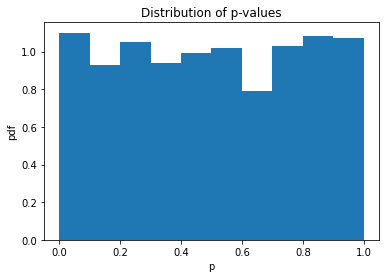

#### Dispersal Histograms:

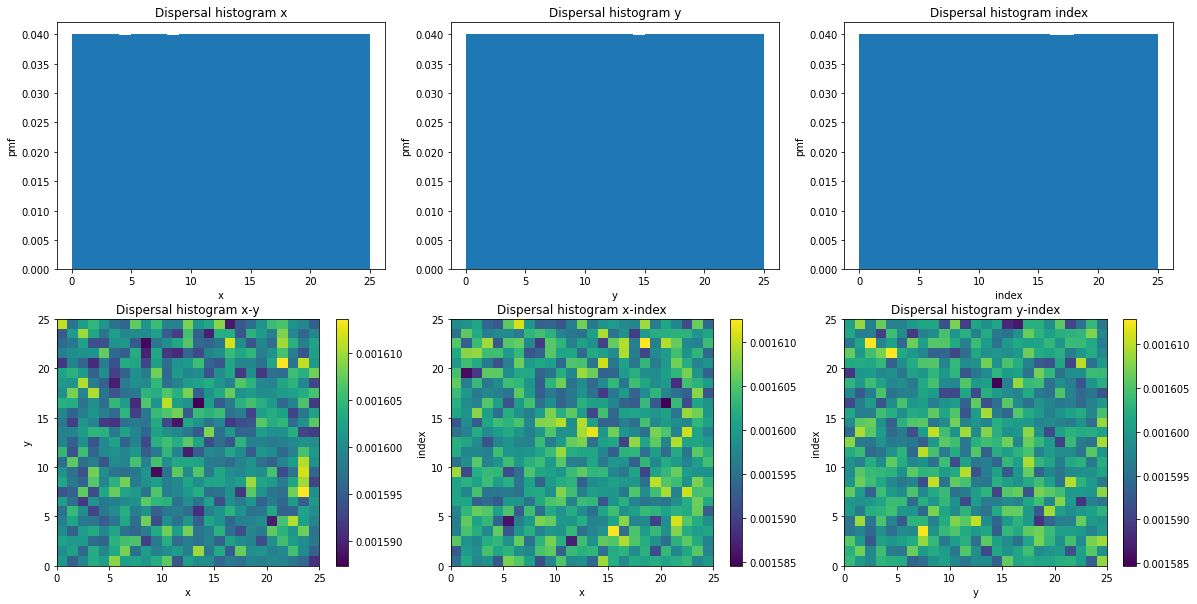

#### Parameters:
* seeds: [13844345676122057167  2723260644960939918 10764895845444784753
  7894693334974888560 10417489073341601970  6912230053462576766
 16264817846197088404 15130573390747178825  6808226284683919909
  4409112194411271738  1374991166141353497 16965778986113379078
  3364661740122794858  4205016538286621814 12500961934286902314
 13131707044962269709    50496459183659656  1626353605732480708
  4761123344733342660 10694265220957417813  8000964557686443110
 15452646481890778569 15120554278791445508 16820218210871777997
  6001287304330344661 10809788587810326296 14741153231417837577
 14692758207242225923  7334240271574061684   434664237368629438
 14542845223996116648   490027649757120822 17693541951045087594
   579236320888183560 11642849619467645926  9138492627341612413
  7972869478320874648  7216630574510788379 16378985156526855449
  8508853826356888157  3080667769897037458  3142046223831768325
 16035745964099482253 14383106847368374428 18053239421331987410
   135006954086428891  8179179559568268133  4636339064303619062
 12788407699620793770  4773913469635107098 16375600641425258084
 13677242117901843208 16297086700126355845 17140798039370542853
 13361686937626097128 11720677322658315446 17437340173785078187
 16866591128036127658  2964226537741697263  2851164589769155329
 16088937824588273453 15223246598505295167  7161205099400361421
  8283539668918564751  9841996207103403442 17535380639043790915
   485279987614497701 14955649258103564927  3592330953570308018
  9238883102662896259  1974330695357755424  3154412756151629979
 17033231682727327459  4331636235571780205  3274576400668433834
  9946689531492667519 18335414989295962519 13115470655687689798
 11774345059104628257 17762977317196829364  5213113064987586033
  7756238954747394262 13584487163842809663 12451237221448818091
  8959230480795395026 17155944550987201113 13903155416490824258
 11198427898547933502  6367181591971968920 15949934777136114400
 17981047253593880672  7395977605330316574 13527312786656565458
 11584199942539186499 14627498280053304471 16656656674338251043
 10469430833759041172 14519830857899255969  4971586650230156670
  3759385930248147362 17705136348490244605 15850929536452091072
 15068992823575556125  4161104875303439417  7908426649606483406
 11377146930203191145  8847768363720797352 10992168578474122039
 10425014185778810390  9726680573340088232  9254930548060230782
 16477065774773227708 11872164938664137769  9593223819772476585
  9930924233794280608 10913315799328452032  2612388342781684466
 11197888944799299549  2053098720881196533   197589995679401038
 15284159479053287636  4479139311078785399   612719343650056650
  2139912433820303187  7733864404603101242  6945460763432259352
 11915969924249558409  2399459784187715250  9021645909332727913
 13919854230207436329  3610439462454177487 17252065487885576009
 13725667752686578909   577099810591355526  9195021188098970236
 13483718870491796768  7809959795122965968 15360123658541019415
  8708898487907402062   726883818277595768 16113178566254556664
  8862194028014561195 13430795815844872277  4139416830231547356
 11266130014799832010 11114980893937044710 14483021558355615366
  8504079789974792470  3594641903905909909  6009899639958867766
 13280860082526960067 15457549609006107888 10293380240985486838
  7599566548434500653  5132013663335493812  5338050931112277148
  6131824372432080786 14540250270281159966 13299284134651237352
  7505916439202788089 14182686881877099999 14223920914882605209
   133610562918947963   457213162067367635 13373215408511123005
 13850877654898630212  4554259209596061291  2220387820073673661
  3584911889749484539  3753429981138214613  3737489151200128066
  2301668888006889492   917214491832448613 17750488392773396594
   690175287282655409 17498421607111804288  6017782370395191071
  3882288519158526684  7520915147507989095  2465794634448178451
  2281301252415224190   772477572570218312  5562436385930677876
 10578591426689022997  1267893500165767922 10509246300258398100
  1514957703499383511  4209623777631375902  6659238319633046789
 15104974366887042756 14033670974605346301  6857115087919949100
 16030328681413831831  4284730755918279325  4710814811869928325
  4882480614135967497  1616458652489475229 14506092329534460961
 17532539991634845972  6978539687846044906 13125079378007650400
 10018761648526181259 16677775321528062240  9263342226449980957
 11265951712971063969  6905608074964162518  1964923943695075165
 12262846652095689796  5701705841001575774  3298967393034189125
  5755540156885427446 15426876857674888290  4430186172841702820
  3750156552349639704 14390991888410215000  2318356491245430195
 10172121653318212008  2610011473177144093  1343665023066206511
  3457251659449724607   118321463509945586 14859312263546101375
  7226536148639722422   233137099042108489  8141710180173651676
  8136020425074344786  5464240354007261056  9445803868018245917
  6811386829723650364 11435950778452208942 15855852260211548070
 10492261975953993921  4609512596800596164 12576875157766957319
 15361944424195602082  1185463022522251217  3819956099911781137
  6175428163344324406  9018281271230506053  2244508454888450201
  1147036062079542897 14414135885487815536 14874952822001928692
  5230421160915332462 14096198915452391113  4398013014554824025
 15255023959242849175  9212934630730060749  9611945160214281033
 18056416510063621179   352183430719801035 10319278095377566299
  3761704560625333210  9763036426866383686  9152997922729589269
 13338752811557311264  9098315788749814190 10773947601577284872
 14343024452719281915  9348082033600493728 10998269114627416094
 11165626042755804724  9015790965755540167 16224461571699242879
 17142107531431374838  6999457262163529051  5033931776358036316
  8435023442426813558    77812559661084212  9947349610626283156
 17883293365581477536  6880885343017578145  9844179627821152462
  8300722705452888026  7056786657033021313  3844939072241920364
  8148238385390361483 12085841047468756886 11928386681922154134
  9517431578558605623 15541862809396418430  1466995917191884329
 13003103845800824117  5057411377170029978  5869402741112582191
 13476180435379485306 11595589046244505349  4389638305837317892
   198436545113550300  1652918329640497121 12429566214783092802
  3774826084397252309 12552240555403616680  7798306520745224928
  7202656393982060172  4470352435595095549 13619692140635725221
  9874950115610638285 12461902153047137480  7223299720425132557
 17232917468960674495 16545457584826470335  2512665039252843788
  8374642019944485929  5184361032996072274  1673231390664942147
  2250512400334667093 10541432435148957343 15340896925934089203
 17045383484568532611 16806510338684166691  4454060055572377998
  6730159956047932978  3606271529962257941  4723582716897126092
 15371353947532154910  4851017506392639834 16269653353941313858
  7308316104203255246  4896832518597318222  4511769436708132640
  1128818785456926465  5630378446126838877  8300008728540255230
 18099198937335866592  5453204958121602751 13431870845207537555
  8467555520154191647 15376028286317542977 16787751609263581796
 13042183061319226613  9353832395582097298  2702326799044085166
  4911797305991306929  5318084563212184826 17951974267054450499
 17630906754589161302 11108119833525881074  4530972189752545855
 14716981041504891836 16460981007282308566  1219880263689151515
 17258174362400715071   101380218034384957 17104751261681962200
 15681890493662059803  6093016355001106405  1391463080183024278
 17434414092638089436 15273319372221976561  2603973304136400457
  9054001081663921717  9608622451302643554 10919989554931747470
 14555534684470387228 12417979956986838471 12770170488303509413
  2610798976199109835 15294471583171455918  6875110415609351812
 16876657626607038257 14593339564619957429 12803196794098536270
   749539324893357527  5601520821345893097 11877251555035759484
   495658983872926853 12750254097922523338  6168154326724920802
  9737776733752329416   640264468021357374  6909456108791396845
 14162907404376661029 14417173648879956699 12271925143210053926
  2461057181776200926  5572956795860109743  4500642953951325980
 11054871528636000360 10235836221363703651 17382513003299346785
   241585721893200194  4646099253437871280 11969977705659809902
  6811325965334285580 11017182034403156756  9883834056740324442
  7140887659598448222  5060756309683745864 10820485726940772268
 11159421715402643118  1933333617472067105  3521154785658174563
  8150696253451586907 13654372125900648370 10501665639705807397
  1444512907066021636  1249448800640543012 16533549462657023483
 17890875461744858112 16113131450968174279 12342185581771706747
  9427919768208419154 15999975379283186011  2061623133366163302
 16723142107583286843  1938648389594219554 15531197168254127987
 13498364039384348069 17186846832470808580  1324183475965910234
 13946649261309175547  8402032079496190695 12835270847021107319
 12660760467815468461  7381606989487370470 18074369529307517436
 16693703409108018271  4709606353766971084  2934534951228041063
 16913687461356361665 13302080947779005982 15687341986233636644
 15777655005269893683 13994074659149603896 10795727014972991598
  8611952469583440002  5687562904818207843 10419338553384589589
 12869708749164514363 12735602451308987666  7980758949613458353
  9327952424599701238 15625201419404466575  8287386894349725014
  5685443942879996182   377209430060264697 14370735458477058186
 15364387250000329734 11000527973500322237  3655907281753335570
 18383401447260187457  9029550388898465366  3533098667783495544
 14452192911046614776  1598417064327431665  4202589749994189536
 13549538706805636201  7384730416838072381 16651614108241035158
    39022611294064196  5955815585706759623  7907414926379736774
  3774708074472702573 15590976498807903067 13856298338204898091
 10604682722665438982  7792609480121836548 15477089711415829194
 11027953887836546322 17452759569745271927  2299417506004422303
  1480514069962063319  8677474769128450830  3787325006056961019
 11319444198359238224  6434166087423663601 15943761163849696288
  6935220208886482478 18071034456874113917  3843870602896990022
 10401873361123666562 13018047460592512801  1518089281358548911
 11247228880852523966  5882901494237205279  3351490597757040105
 15755660730656806618 10387412508754051942  3279465914652561065
 18429137513720913711  9330162927793516240  4872392384892382287
  3139757978704462223  6260281661925728622 17921763301085091134
  2548347901193817660  7210513471366085476  8129382956738693448
  8900804450239768190  8034477407497667800 16115533818621172772
  5945924686783069768   714500493419630954  8833847803719269742
  9540407384994780542 17397700922206432189 10269419871860015874
 13484305830232315233 11190918836443067741   462271238449958266
  6410812121107192127   277350612724717784  8994051569376995909
 12197230961576189248  4414642567118781905  7767296223548405293
 13040112448007836328 17470262906169439536  2919301384246738748
  5235882734830260411  2255178267326890212  3808214194922180904
  6527914702235337393  2382717550571439945  5803776317728570324
  9777717321443934370 12119302827840340945 18130789501053216905
  6974890491564321784  6111241080301471925  8992761920661349885
  2190763901515712270 14954231339542154266  7455817402381625399
 17766042588320053841 10494944138378602318  5573965928454687788
 12320598268838011772  8400595332426506850   209439537533669943
 14535804706969690218  5124929858653463434  7977032100759400391
 14538773686369885408 12503687392141108532  3776092460212251712
  6550958054059465866  5838805032325482555  5795398245400635080
  4508031054980740367  4954463249290868473 17795014766175685967
 15328787461140185831 18361789232263438099 16560455513566802959
 12827526072896337396  6744692207019349333  2451584857866376516
  1023320397866046744  3944623407260200032 11566825010034429166
  7220280459071726834  3731864433212377319  7447473940254016124
 12061616102356925638  7815362244086494802  5347019860869424141
 16969938959550109365  1816667129470867451  6876209907166511755
 12978526722658600759 16185843213185209472  3960394488489626021
  8711424342889203746 12133829704916714779  3826217012889078455
  4374281416749994532 17538886907066755131  3150789104151399994
  9610396018283692380  8557890507935835658  5463975733711364334
  1232166154609520325  5750493859874850637 17696487140365334070
 15354229029194908736  7826727192325207974 11422613691062889190
 10137006816100047958 10872960668110890966  9352721728877217464
  8188736949060458650  1961938616391344676  5052420875152569123
   762518376574209276  1277498307280718589 10808763085111331446
 15157858256459604646 10337659319136253584 17540714643303957370
  5921674505446336582  6477925568452750775  3642275536186175682
 18370769218457230909 16121344553455136712  4764861262679450912
  3142854166160329215  9270519514139916849  5555950408159904280
 13630636711436700161 14207460125725458327  5208582637463878378
 13030944470412355231  3010445574087437387  5243715111517291999
  1121506360253968487 12407573208894298584 10086583745351512599
 16573862270951154722 10189457299743709686   963949524990693974
 15368604557328530698  2853188198790446527  9814926414073759875
  6952027651637667760  1456515057931852068 11929880812930987531
 11936726057397877305  7548540564876525661  9215312431986590477
 14770186910723321033  9731383479586970061  1969989963415370464
  5763147812062507090 12324952543525926725 17304455188580431215
 11074351547922960168 17662277632613597447 12767674676955431385
 14217972661001022939 14986875961040002515  3315107635922359923
  3500141574152391561 16045217393835363624  1231980542131685292
  2793943994852856658  8498639860323107251  6059765137833502479
 14411216644630608418  6065518299459471195 11848883048245210544
  3273343136460247237 13031044252287410217  3462071037557691293
  3165869263158362198  6086353108679429832  1968126416828918308
  3068785279555349284 13834986094697396089 16103594212291013332
  9147030358129099397  6488932296536120071 14278674680615684608
  1731195004968950698   334419813976652180  4718835236244400572
  4685405714421501257 11122269956874580119 16141697326077086661
  3843758596594958100  6922740763695678918 17048741995141218145
 18111673176478952958  8981807946908102996 12134668413252418419
  8581701891357654401  7137245150751431366  5700966984952130974
  5445621610979228184  7127713634661928330  6104772308933970757
 12471131591888562462  6336981259831384429 13061398390085750078
  2070786574015341192  4221924115089732385  7621624858933233784
  9108111302483296531 15436471469815601096 16997861260419870220
  4015310891283159180  3017719164916752961 15538031515054269946
  1666217728811603775  9320440147870452403  9693558898903022074
 16427808297492924773  8754338584748006533 15677078508546620141
  2681914775511037228 12655844248877821969  1542658766134116999
 10679464789710366348  1247379400073632554 15750966958021465708
  2504289426105940022 14552534843744333005 11634000188075385046
  6178117102298534799  9185426100962390507  4908266206114177899
  6257233882356704491 15281031519889418605  6333054862891869079
  4561103760920527358   290666130745730796 14280569851791183960
  9941758374136082552  1820816796363419958  7997281239778800218
 10968788220467813938 16922584047279511642  5223677864215029665
 18380664895280761593 11444228552040798081  3468196310647237508
 10436602419102286964  7526178576744213806 13223898471226759050
 16969973242023579641 10132083219827457734  6495446332473438335
  2986786167625217711 11949082040557994839  5916793327651977608
 17238771764447772897  7730245347362892263  5637871862782111118
   558990294367906810 11498455805856833353 12432137961423624366
  6959744128566627498  6793802626259492026 16762143531619846033
  4882158638633870562  5576307796683285160  5487409350272470714
 17389957025249213988 17155126391948691790  6990206251149712923
 13631407125170890604 17630155917729684247  9125875266597407760
  3127701818982160742   789218967957717199 12392975215563553580
  2331153622777916783  1139471365991996398 12634640387917817682
 11014370636565293516 13461970931306772469  4266417830577562005
  4662359337657432495  5587073057552379334 10852557335099090061
   536252461341269539 13584724591748758318  3501910533927968899
  6517561876612000801 13909492499799638645 13264947227330607679
  8358510224355244464 10711388097136163145  3429000685465461708
 17062126649594503346 14792511999500149367 13888902510968293049
  6655836426246449732 15120656085734868908  8736285202289905450
  7429011498800020407  1422687181915830061 12843145597364869162
  6072308970868342890 10728893584511096649   575566706367220758
 14347359484350027366 17938164758690239677  1161056191204179229
 10041935470499594200 16976157666948733361 13218539026328861506
  6827005214951750274   371270775533031234 11859937184477984077
 17895653911873838746  5760306129689932145  2683669967930910363
  7634988333257303853 11484768219272861975 10213351902676425890
   836711170288341595   261969708079922311  4231356262319927893
 13961820691322935802  1010859731150737148  8346554952273643400
  7928544443175177098  6218754248571079666 10132614950385315274
 16968330999381373920  2076910932758870469 16482057478467672327
 14672692674734481187 15039333112439448628 18033692964964391322
  8878122520437124772 18237920741579543509 11566304081123143399
 17832114171054893320 14568142166878567044 13383240075480679898
  1175787904086397846   298510727616218900  4098676050199071314
  6874828186485495752  4564080838964860242 17469028434521065498
   741267902769945037  2515002059659660038 18414535720424211359
  4291752505772625410 15701835572135721008 16424403933391923564
  3345524396486456533 10782968090851470362   347388880672851643
  9004959966522616791  7121945271878463202 10829306017350936643
   538168224991419062 16565089039016731795  6555938161717107733
  5802714846343136523   588638552961707527 18005796881138052085
  2697679429353493082 13226473920654178965  1961900013452820741
  3122681687336575169 11836699446143660106  4124925463995051911
 10153925545835936510 11510576089096618550  7957738433975578953
  1221476231696856533 12035635670228146412 17760682370544133537
 17209860791694003964  1771755967562183822   408488447344850712
  8793931018743987954  3130063286852536981  4338777270479065018
 16740247563255434593  4369971629247736983 12096617996633510423
 17657204461566827094 12366628743416905565  2072141801506642488
 16539978620042180937  9724113605825034262  3160689647762044642
 16617370693954519110 11512158374070813036  9412302132789872065
  3420322842035606745 12476692749303230051 13306396251670980149
  1396627307229689622  6354906266112907976  2605753833045595391
 15122028713006881779  1235860277894026493  3799021084587335502
 15016801615018931291  5058006742786745003 12414626142240673645
  4202268095195771881  7502811920228943333 14828165987219640019
 15888391937702050575  1439888083070399605  1388162661388906900
 16362171697927644041  3482549855943809216  1246003679353942578
  5482936191739561080   601478153871691466  9402462254719308718
  1911239724079371071 15810180575319679808  6797983506718472941
 13474709584832783733  2175760799169178381 17071057362361303918
  2963944752560412420  8422711044644180093  5677473358402048974
 11237166266039629534 13289191533844529216 18227160846455372717
  5652352069472952153  7884835565881537999 12518448056054288297
 14051156353153773102   573911071715962274 11712251585957524842
 14198950042302983051  2502266643266295720  8893902540477430957
  6714502199195993029 12386761470519545326  9369720016825118644
  5150150336302406804 10736561955914517139  9075291283599886315
  5691098743979079757  4841568519666717626 14629635040955163120
 16618162609994523524  4806482958899402687  5042892635524039528
  5596369279903087873  4001670630020263750  9452301096158454734
  3458295509799837314  4674486773587239270  9091496176881650451
  1709111008702976021   406069114467963524  6759983877535487326
  5549868059358684568  5156689646381395716  5845831505699299194
  3376306100345775186 14688069920828758412  4482780279756130723
  5763599233095062515 12780885763539851037  3625968502985999325
 15206557048303697068  5404332584194349629 14547839747128053770
 12228721336316308958 16945659156087789734  4704362215220856752
 14359730487015492062 14569612205056484519 15491939457775864573
 15889130737206110024 13644723727888317445  5198871139077074427
 11018168439715249494 12314454112490109890  7307144940943427413
   281869734628716987 11694873109556130328  7537839219860331013
 16272188208459762828 12858860945472952120 16610967346153269568
  9289727620625235691  7513298035160822871  2801560555049425322
  3530938680404947513 12268373177541440795 13478420794019343589
  1534442383373185141  2003708661946862320 17921208283664527211
 17549424603118785579  8007771937658021449  2176340305883028776
 10083905045926682172  7335818602937279406  2159864151122207307
  2991196069473171217  6925035174149871583 18245766980867264358
  2127176684777451882  3422782596165715105   727212125733936498
 14792566915110351049 13090835366115326118  8299962335182290305
  4885769239265897908 15363278078579377149  6034134756902261463
  1491703292156644045  5786687573150126989 11154564592784320325
  5968255128590131105 15110715312185943539 10938334856197283295
  3788925103888018957 14605114093501297450 18254519865298031319
  2901416952515149860]

#### Configuration:
```rust
(speciation:0.0001,seed:2901416952515149860,sample:0.01,algorithm:Independent(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/home/ml5717/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_nonspatial_dispersal_coverage(
        algorithm, size=25, seeds=seeds, sample=0.01, speciation=0.0001
    )